In [1]:
import pandas as pd
import numpy as np
import urllib.request
from zipfile import ZipFile
from re import compile
from pathlib import Path
from shutil import rmtree
deis_data = Path('deis_data')
deis_data.mkdir(parents=True, exist_ok=True)

def get_deis_death_url():
    datapattern = compile('http.*DEFUNCIONES_FUENTE_DEIS_2016_.*zip\"\\n\"tags\":\"defunciones\"')
    with urllib.request.urlopen('https://deis.minsal.cl/wp-admin/admin-ajax.php?action=wp_ajax_ninja_tables_public_action&table_id=2889&target_action=get-all-data&default_sorting=manual_sort') as f:
        return datapattern.search(f.read().decode().replace(',','\n')).group().replace('\\', '').split('"')[0]

def get_csv_deis():
    url = get_deis_death_url()
    urllib.request.urlretrieve(url, 'deis_data/' + url.split('/')[-1])
    with ZipFile('deis_data/' + url.split('/')[-1], 'r') as zip_ref:
        zip_ref.extractall('deis_data')
    return url.split('/')[-1][:-3]

def annos(row):
    edad = row['EDAD_CANT']
    tipo = row['EDAD_TIPO']
    if tipo == 1:
        return edad
    elif tipo == 2:
        return edad/12
    elif tipo == 3:
        return edad/365
    elif tipo == 4:
        return edad/365*24
    else:
        return np.nan
deis_csv = 'deis_data/' + get_csv_deis() + 'csv'
columnas = ['ANO_DEF', 'FECHA_DEF', 'GLOSA_SEXO', 'EDAD_TIPO', 'EDAD_CANT', 'CODIGO_COMUNA_RESIDENCIA', 'GLOSA_COMUNA_RESIDENCIA', 'GLOSA_REG_RES', 'DIAG1', 'CAPITULO_DIAG1', 'GLOSA_CAPITULO_DIAG1', 'CODIGO_GRUPO_DIAG1', 'GLOSA_GRUPO_DIAG1', 'CODIGO_CATEGORIA_DIAG1', 'GLOSA_CATEGORIA_DIAG1', 'CODIGO_SUBCATEGORIA_DIAG1', 'GLOSA_SUBCATEGORIA_DIAG1', 'DIAG2', 'CAPITULO_DIAG2', 'GLOSA_CAPITULO_DIAG2', 'CODIGO_GRUPO_DIAG2', 'GLOSA_GRUPO_DIAG2', 'CODIGO_CATEGORIA_DIAG2', 'GLOSA_CATEGORIA_DIAG2', 'CODIGO_SUBCATEGORIA_DIAG2', 'GLOSA_SUBCATEGORIA_DIAG2']
deis = pd.read_csv(deis_csv, sep=';', parse_dates=[1], header=None, names=columnas, index_col=False, encoding='latin-1')
deis.set_index(['FECHA_DEF'], inplace=True)
deis.sort_index(inplace=True)
# CODIGO_CATEGORIA_DIAG1 U07 > covid19
rmtree(deis_data)
deis['EDAD_ANOS'] = deis.apply(annos, axis = 1)
deis['ANO_DEF'] = deis['ANO_DEF'].astype('int32')
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 999]
bins_10s = [0, 10, 20, 30, 40, 50, 60, 70, 80, 999]
labels = ['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
labels_10s = ['00-09', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
deis['agerange'] = pd.cut(deis.EDAD_ANOS, bins, labels=labels, include_lowest=True, right=False)
deis['agerange_10s'] = pd.cut(deis.EDAD_ANOS, bins_10s, labels=labels_10s, include_lowest=True, right=False)


/var/folders/33/kgv35mp95jd5fxbx_lqm8mkm0000gn/T/ipykernel_75349/1025095267.py:38: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  deis = pd.read_csv(deis_csv, sep=';', parse_dates=[1], header=None, names=columnas, index_col=False, encoding='latin-1')


In [ ]:
import calendar
import os

import aesara.tensor as at
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (at.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / at.sqrt(n_out)
        out = at.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax, col='C1', label='Forecast'):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color=col, lw=3, label=label,)

def plot_xY95(x, Y, ax, col='C1', label='Forecast'):
    quantiles = Y.quantile((0.05, 0.5, 0.95), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.05, 0.95]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color=col, label=label,)


# default figure sizes
figsize = (10, 5)

# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

In [ ]:
deis_gruped = pd.pivot_table(deis, values=['EDAD_CANT'], index=['FECHA_DEF'],
                    columns=['GLOSA_SEXO', 'agerange_10s'], aggfunc='count')['EDAD_CANT'].resample('W-Mon').sum()
deis_prepandemia = pd.pivot_table(deis.loc[(deis['ANO_DEF'] <= 2019)], values=['EDAD_CANT'], index=['FECHA_DEF'],
                    columns=['GLOSA_SEXO', 'agerange_10s'], aggfunc='count')['EDAD_CANT'].resample('W-Mon').sum()
deis_gruped = deis_gruped.sum(axis=1).iloc[1:-2]#.groupby(pd.Grouper(freq='W')).sum().iloc[1:-1]
deis_prepandemia = deis_prepandemia.sum(axis=1).iloc[1:-1]#.groupby(pd.Grouper(freq='W')).sum().iloc[1:-1]

In [ ]:
deis_prepandemia

FECHA_DEF
2016-01-11    1853
2016-01-18    1942
2016-01-25    1895
2016-02-01    1895
2016-02-08    1827
              ... 
2019-12-02    2000
2019-12-09    1896
2019-12-16    1873
2019-12-23    1967
2019-12-30    2020
Freq: W-MON, Length: 208, dtype: int64

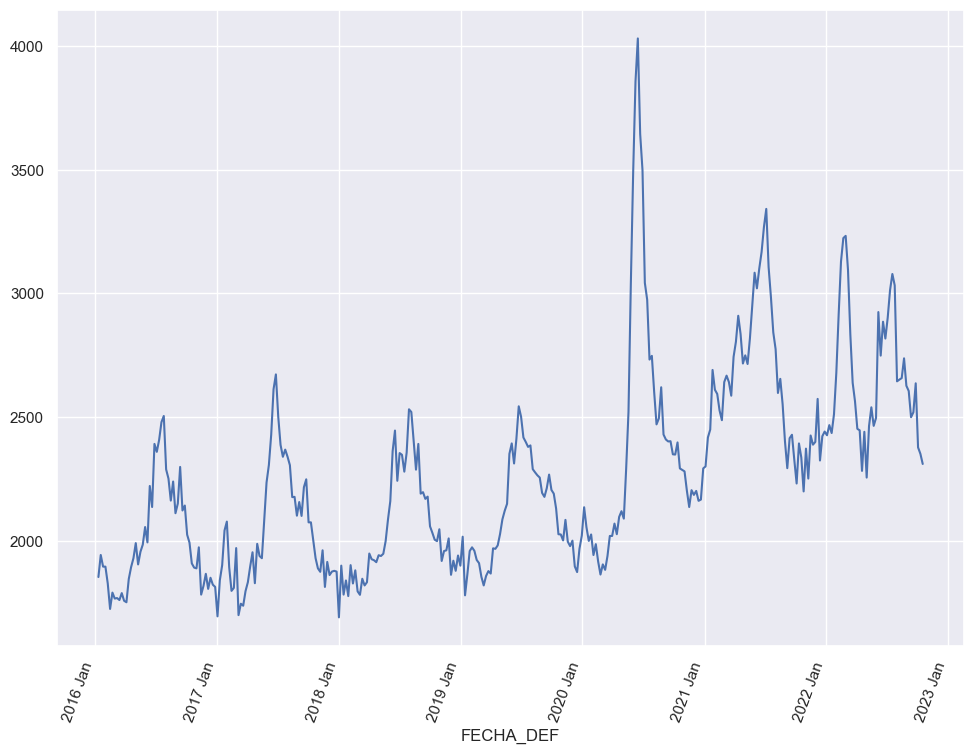

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data=deis_gruped)
format_x_axis(ax)

In [ ]:
defu = pd.DataFrame(deis_prepandemia, columns=['defunciones'])
defu['año'] = defu.index.year
defu['mes'] = defu.index.month
defu['dia'] = defu.index.day_of_year

In [ ]:
deis_prepandemia

FECHA_DEF
2016-01-11    1853
2016-01-18    1942
2016-01-25    1895
2016-02-01    1895
2016-02-08    1827
              ... 
2019-12-02    2000
2019-12-09    1896
2019-12-16    1873
2019-12-23    1967
2019-12-30    2020
Freq: W-MON, Length: 208, dtype: int64

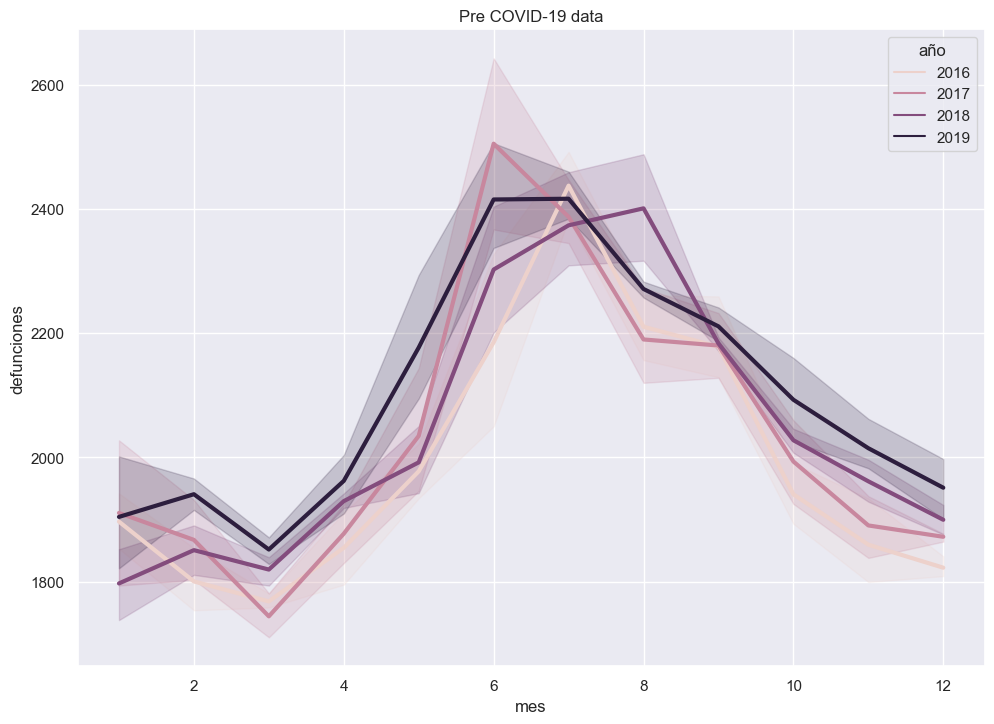

In [ ]:
ax = sns.lineplot(data=defu, x="mes", y="defunciones", hue="año", lw=3)
ax.set(title="Pre COVID-19 data");

<AxesSubplot:xlabel='año', ylabel='defunciones'>

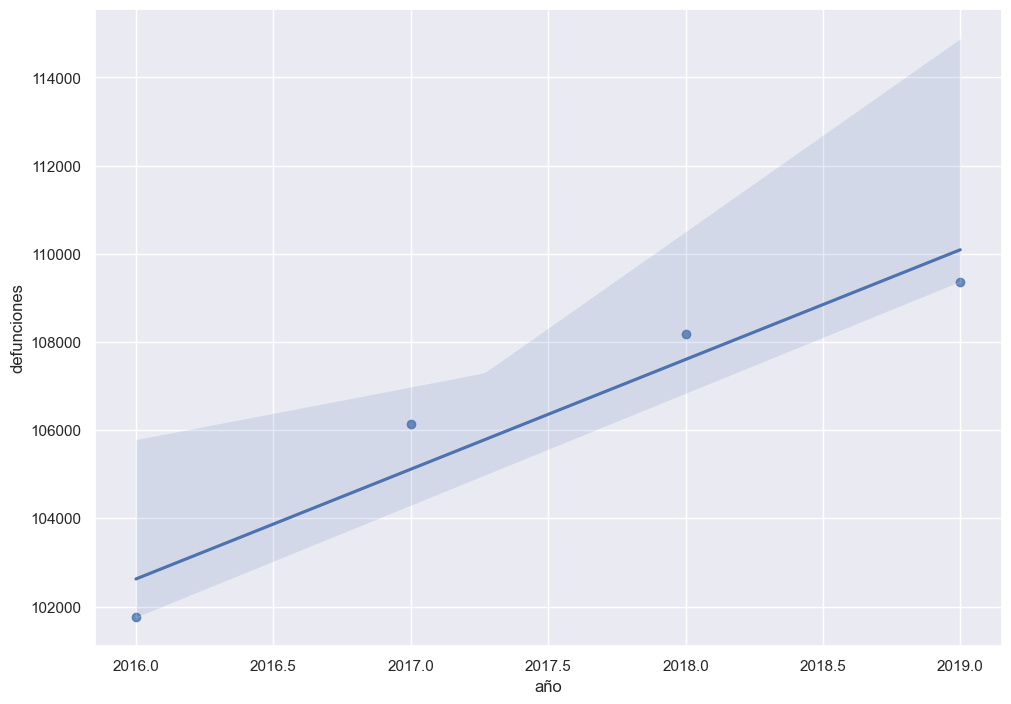

In [ ]:
annual_deaths = pd.DataFrame(defu.groupby("año")["defunciones"].sum()).reset_index()
sns.regplot(x="año", y="defunciones", data=annual_deaths)

In [ ]:
slope, intercept = np.polyfit(annual_deaths["año"], annual_deaths["defunciones"], 1)
print(f"{slope:.0f} defunciones/año")


2489 defunciones/año


In [ ]:
with pm.Model(coords={"month": month_strings}) as model:

    # observed predictors and outcome
    month = pm.MutableData("month", deis_prepandemia.index.month.to_numpy(), dims='t')
    time = pm.MutableData("time", np.array(list(range(len(deis_prepandemia)))), dims='t')
    deaths = pm.MutableData("deaths", deis_prepandemia.to_numpy(), dims='t')
    # priors
    intercept = pm.Normal("intercept", 2200, 10)
    month_mu = ZeroSumNormal("month mu", sigma=200, dims="month")
    linear_trend = pm.TruncatedNormal("linear trend", 0, 0.1, lower=0)

    # the actual linear model
    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * time) + month_mu[month - 1],
    )
    sigma = pm.HalfNormal("sigma", 1)
    # likelihood
    pm.TruncatedNormal("obs", mu=mu, sigma=sigma, lower=0, observed=deaths, dims='t')


$$\Large Defunciones =  TendenciaAnual * Tiempo + CoeficienteCicloMensual[12] + intercepto $$


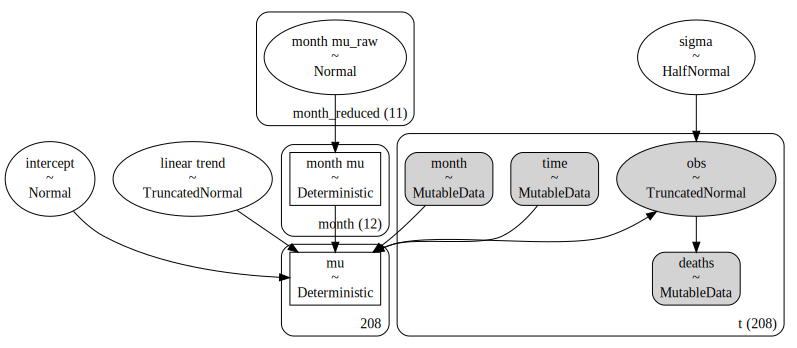

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
with model:
    idata = pm.sample_prior_predictive(random_seed=42)


fig, ax = plt.subplots(figsize=figsize)

plot_xY(deis_prepandemia.index, idata.prior_predictive["obs"], ax)
format_x_axis(ax)
ax.plot(deis_prepandemia.index, deis_prepandemia, label="observed")
ax.set(title="Prior predictive distribution in the pre COVID-19 era")
plt.legend();


In [15]:
with model:
    idata = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, month mu_raw, linear trend, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


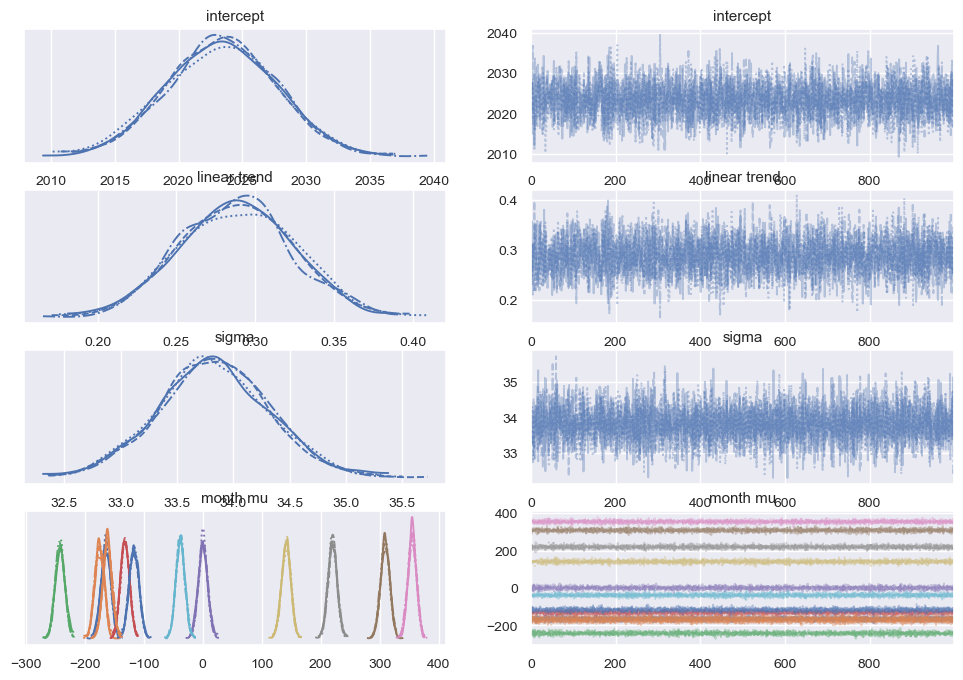

In [16]:
az.plot_trace(idata, var_names=["~mu", "~month mu_raw"]);

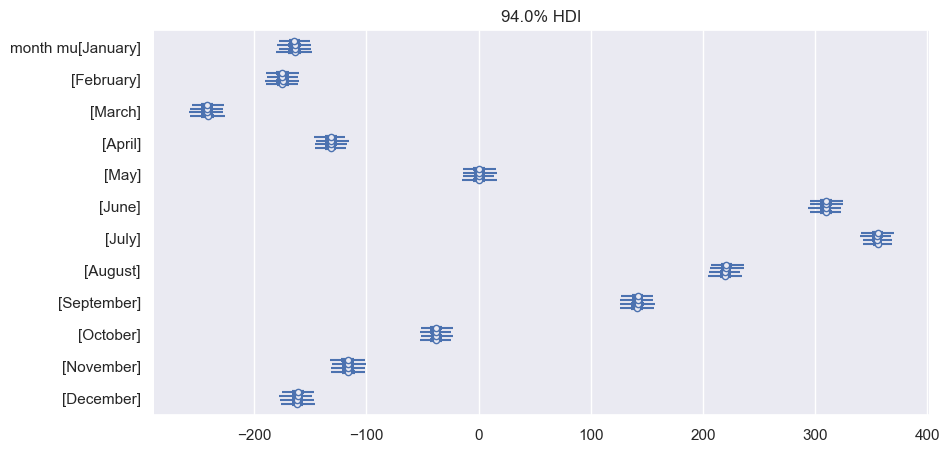

In [17]:
az.plot_forest(idata.posterior, var_names="month mu", figsize=figsize);

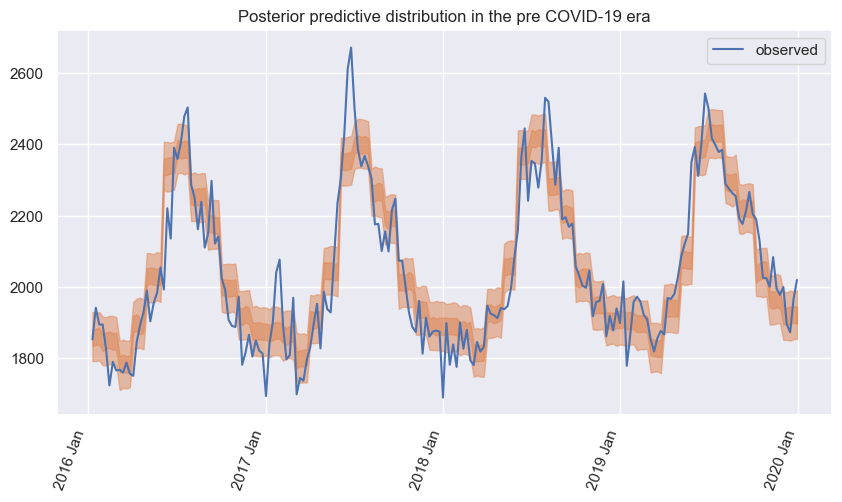

In [18]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=42))


fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(deis_prepandemia.index, idata.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(deis_prepandemia.index, idata.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(deis_prepandemia.index, deis_prepandemia, label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre COVID-19 era")
plt.legend();


In [19]:
with model:
    pm.set_data(
        {
            "month": deis_gruped.index.month.to_numpy(),
            "time": np.array(list(range(len(deis_gruped)))),
        }
    )
    completecounterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=42
    )


In [20]:
humanweek = deis_gruped.shift(-7, freq='D')
humanweek

FECHA_DEF
2016-01-04    1853
2016-01-11    1942
2016-01-18    1895
2016-01-25    1895
2016-02-01    1827
              ... 
2022-09-12    2519
2022-09-19    2636
2022-09-26    2377
2022-10-03    2351
2022-10-10    2310
Length: 354, dtype: int64

/var/folders/33/kgv35mp95jd5fxbx_lqm8mkm0000gn/T/ipykernel_75349/2803263464.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


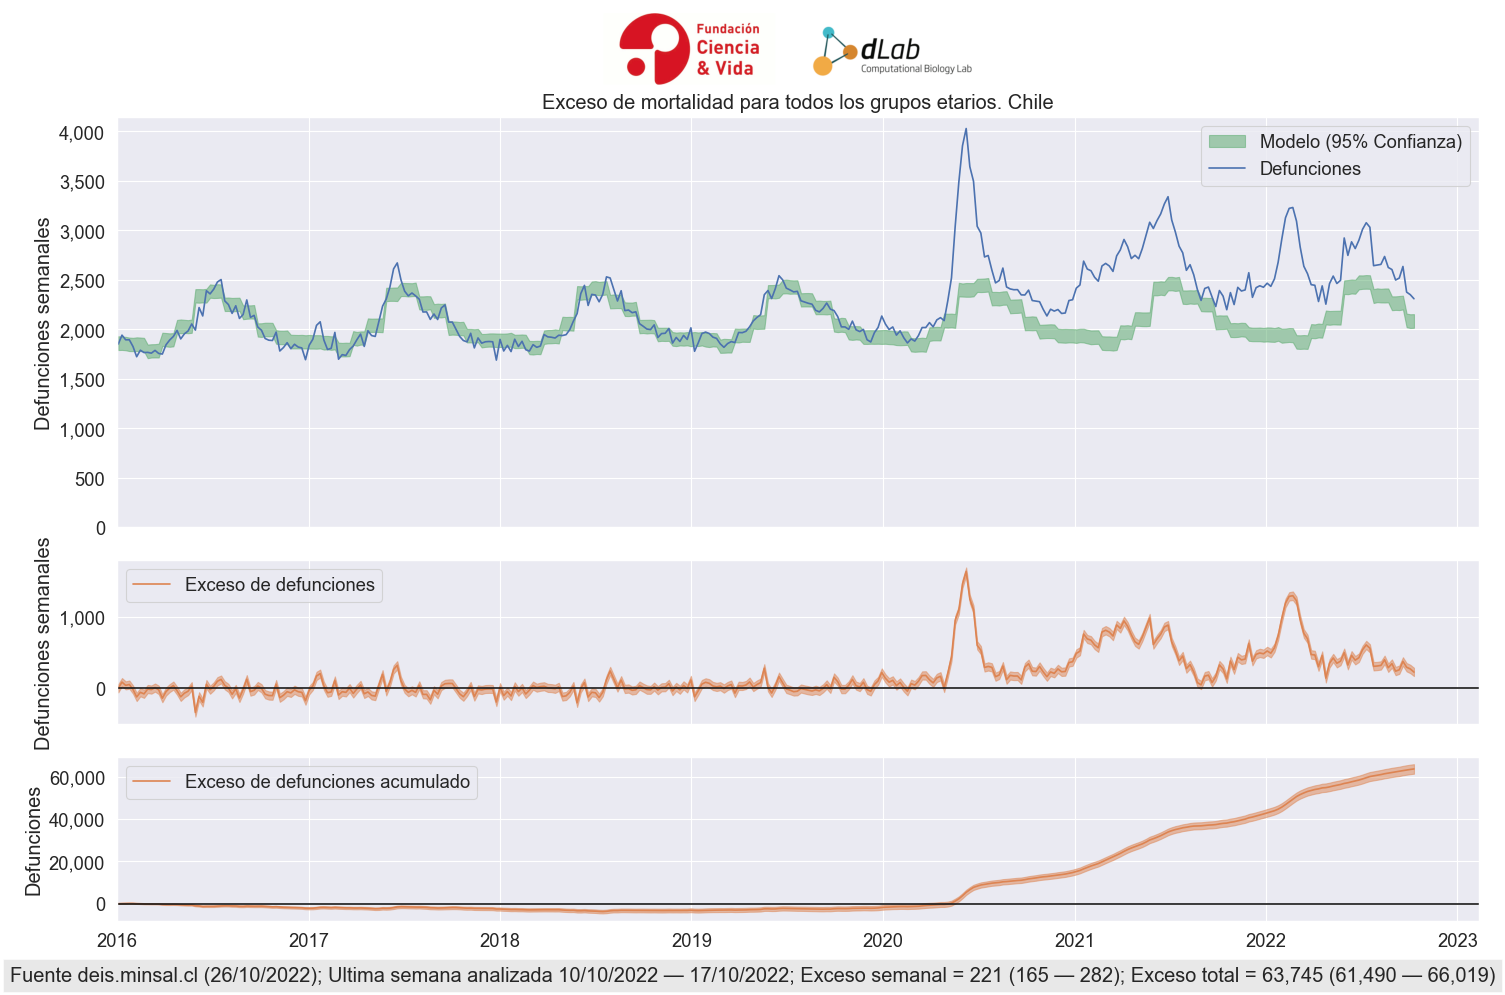

In [30]:
import matplotlib
import seaborn as sns
import datetime
import imageio
TITULO = "Exceso de mortalidad para todos los grupos etarios. Chile"

sns.set_context('paper', font_scale=1.5)

fig, ax = plt.subplots(3, 1, figsize=(figsize[0]+5, 9), sharex=True, gridspec_kw={'height_ratios': [5, 2, 2]})
#az.plot_hdi(mdates.date2num(humanweek.index), completecounterfactual.posterior_predictive["obs"], hdi_prob=0.5, smooth=True)
az.plot_hdi(mdates.date2num(humanweek.index), completecounterfactual.posterior_predictive["obs"], hdi_prob=0.95, smooth=False, smooth_kwargs={'window_length':11}, fill_kwargs={"label": "Modelo (95% Confianza)"}, color="C2", ax = ax[0])

ax[0].plot(humanweek.index, humanweek, label="Defunciones")
#format_x_axis(ax)
ax[0].set(title=TITULO)
ax[0].legend()
ax[0].set_ylim(ymin=0)
ax[0].set_ylabel('Defunciones semanales')

# convert deaths into an XArray object with a labelled dimension to help in the next step
deaths = xr.DataArray(humanweek.to_numpy(), dims=["t"])

# do the calculation by taking the difference
excess_deaths = deaths - completecounterfactual.posterior_predictive["obs"]
cumsum = excess_deaths.cumsum(dim="t")

thm = cumsum.transpose(..., "t").quantile((0.05,0.5,0.95), dim=("chain", "draw")).transpose()[-1].to_numpy()
thm2 = excess_deaths.transpose(..., "t").quantile((0.05,0.5,0.95), dim=("chain", "draw")).transpose()[-1].to_numpy()
NOTAS = [
    f"Fuente deis.minsal.cl ({deis.index[-1].strftime('%d/%m/%Y')}); Ultima semana analizada {humanweek.index[-1].strftime('%d/%m/%Y')} — {humanweek.shift(7, freq='D').index[-1].strftime('%d/%m/%Y')}; Exceso semanal = {thm2[1]:,.0f} ({thm2[0]:,.0f} — {thm2[2]:,.0f}); Exceso total = {thm[1]:,.0f} ({thm[0]:,.0f} — {thm[2]:,.0f})",
]
enTITULO = "Excess mortality for all age groups. Chile"

plot_xY95(humanweek.index, excess_deaths.transpose(..., "t"), ax[1], label='Exceso de defunciones')

ax[1].axhline(y=0, color="k")
ax[1].legend()
ax[1].set_ylabel('Defunciones semanales')

plot_xY95(humanweek.index, cumsum.transpose(..., "t"), ax[2], label='Exceso de defunciones acumulado')
ax[2].axhline(y=0, color="k")
ax[2].legend()
ax[2].set_ylabel('Defunciones')
ax[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[2].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.figtext(0.5, -0.01, NOTAS[0], ha="center", bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
ax[0].set_xlim(xmin=datetime.datetime(2016, 1, 1, ))
ax[1].set_xlim(xmin=datetime.datetime(2016, 1, 1, ))
ax[2].set_xlim(xmin=datetime.datetime(2016, 1, 1, ))


img = imageio.v2.imread('https://i2.wp.com/dlab.cl/wp-content/uploads/2016/08/LogoWebDlab.png')

# put a new axes where you want the image to appear
# (x, y, width, height)
imax = fig.add_axes([0.40, 0.9, 0.25, 0.25])
# remove ticks & the box from imax 
imax.set_axis_off()
# print the logo with aspect="equal" to avoid distorting the logo
imax.imshow(img, aspect="equal")

plt.tight_layout()
plt.savefig('foo.png', bbox_inches='tight', dpi=300)


/var/folders/33/kgv35mp95jd5fxbx_lqm8mkm0000gn/T/ipykernel_75349/4064004305.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


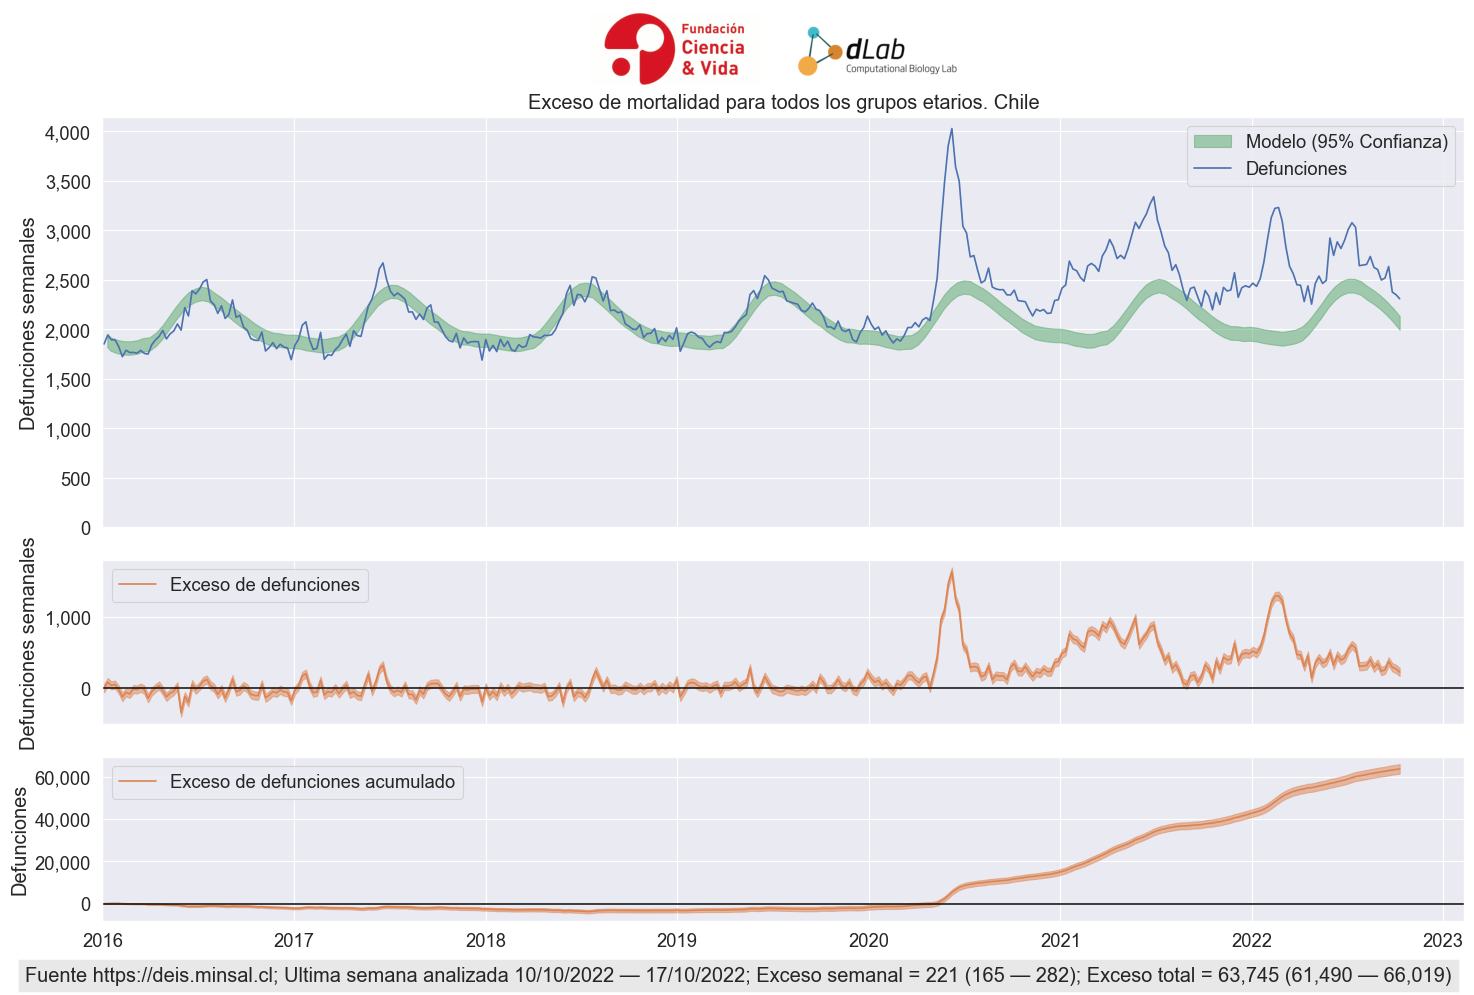

In [26]:
import matplotlib
import seaborn as sns
import datetime
sns.set_context('paper', font_scale=1.5)

fig, ax = plt.subplots(3, 1, figsize=(figsize[0]+5, 9), sharex=True, gridspec_kw={'height_ratios': [5, 2, 2]})
#az.plot_hdi(mdates.date2num(humanweek.index), completecounterfactual.posterior_predictive["obs"], hdi_prob=0.5, smooth=True)
az.plot_hdi(mdates.date2num(humanweek.index), completecounterfactual.posterior_predictive["obs"], hdi_prob=0.95, smooth=True, smooth_kwargs={'window_length':11}, fill_kwargs={"label": "Modelo (95% Confianza)"}, color="C2", ax = ax[0])

ax[0].plot(humanweek.index, humanweek, label="Defunciones")
#format_x_axis(ax)
ax[0].set(title=TITULO)
ax[0].legend()
ax[0].set_ylim(ymin=0)
ax[0].set_ylabel('Defunciones semanales')

plot_xY95(humanweek.index, excess_deaths.transpose(..., "t"), ax[1], label='Exceso de defunciones')

ax[1].axhline(y=0, color="k")
ax[1].legend()
ax[1].set_ylabel('Defunciones semanales')

plot_xY95(humanweek.index, cumsum.transpose(..., "t"), ax[2], label='Exceso de defunciones acumulado')
ax[2].axhline(y=0, color="k")
ax[2].legend()
ax[2].set_ylabel('Defunciones')
ax[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[2].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.figtext(0.5, -0.01, NOTAS[0], ha="center", bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
ax[0].set_xlim(xmin=datetime.datetime(2016, 1, 1, ))
ax[1].set_xlim(xmin=datetime.datetime(2016, 1, 1, ))
ax[2].set_xlim(xmin=datetime.datetime(2016, 1, 1, ))

img = imageio.v2.imread('https://i2.wp.com/dlab.cl/wp-content/uploads/2016/08/LogoWebDlab.png')

# put a new axes where you want the image to appear
# (x, y, width, height)
imax = fig.add_axes([0.40, 0.9, 0.25, 0.25])
# remove ticks & the box from imax 
imax.set_axis_off()
# print the logo with aspect="equal" to avoid distorting the logo
imax.imshow(img, aspect="equal")

plt.tight_layout()


/var/folders/33/kgv35mp95jd5fxbx_lqm8mkm0000gn/T/ipykernel_75349/4203836653.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


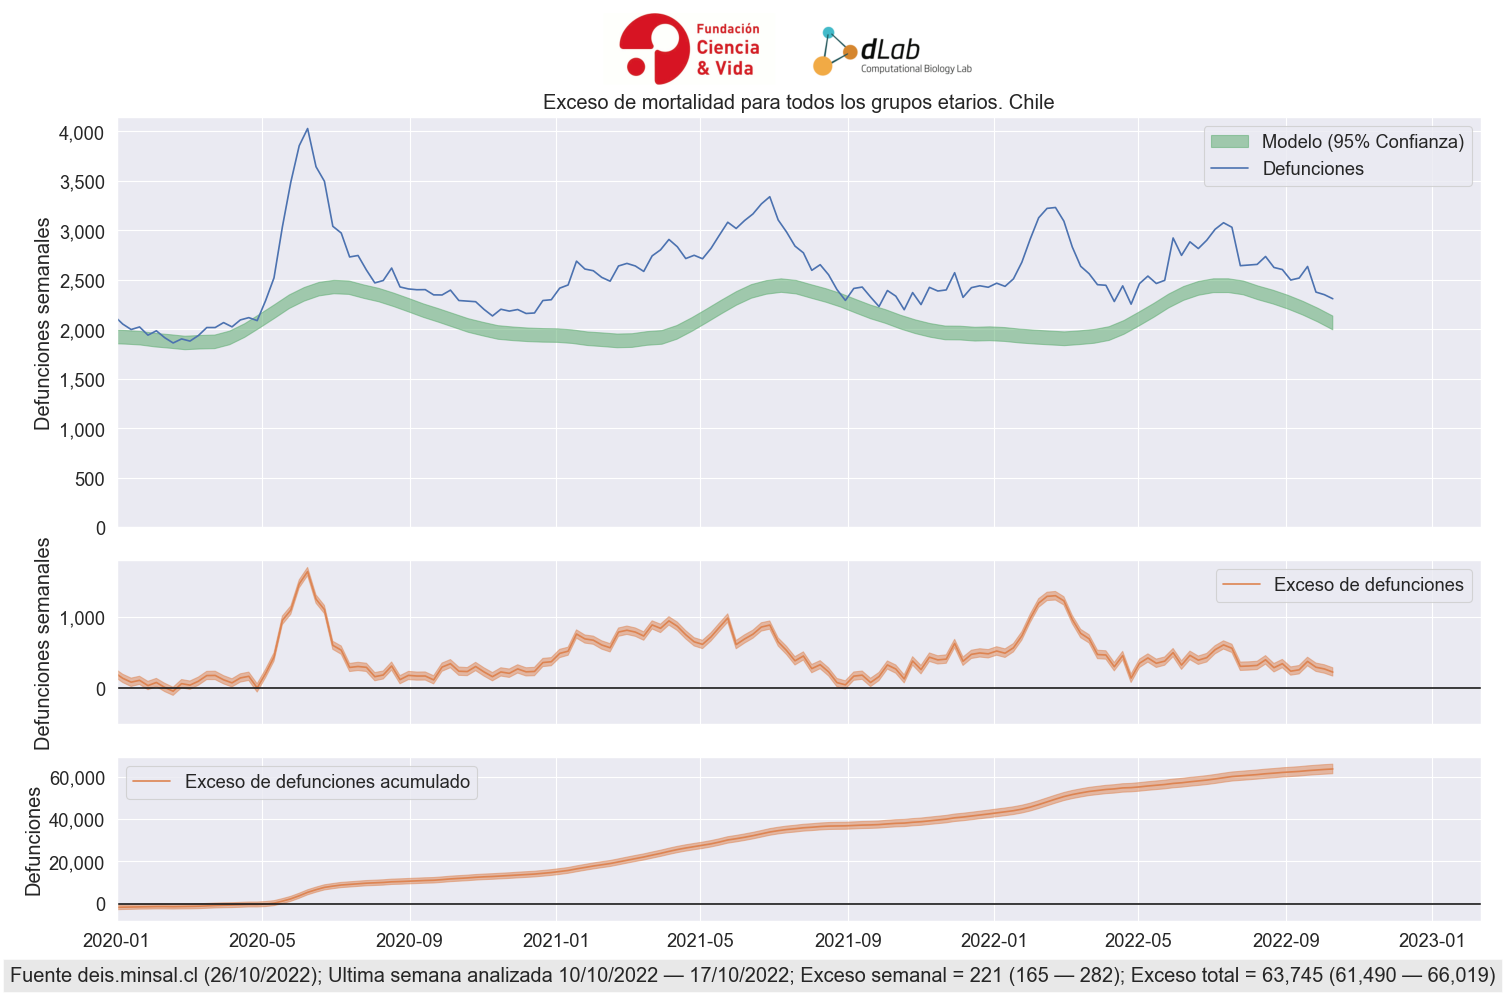

In [31]:
sns.set_context('paper', font_scale=1.5)

fig, ax = plt.subplots(3, 1, figsize=(figsize[0]+5, 9), sharex=True, gridspec_kw={'height_ratios': [5, 2, 2]})
#az.plot_hdi(mdates.date2num(humanweek.index), completecounterfactual.posterior_predictive["obs"], hdi_prob=0.5, smooth=True)
az.plot_hdi(mdates.date2num(humanweek.index), completecounterfactual.posterior_predictive["obs"], hdi_prob=0.95, smooth=True, smooth_kwargs={'window_length':11}, fill_kwargs={"label": "Modelo (95% Confianza)"}, color="C2", ax = ax[0])

ax[0].plot(humanweek.index, humanweek, label="Defunciones")
#format_x_axis(ax)
ax[0].set(title=TITULO)
ax[0].legend()
ax[0].set_ylim(ymin=0)
ax[0].set_ylabel('Defunciones semanales')

plot_xY95(humanweek.index, excess_deaths.transpose(..., "t"), ax[1], label='Exceso de defunciones')

ax[1].axhline(y=0, color="k")
ax[1].legend()
ax[1].set_ylabel('Defunciones semanales')

plot_xY95(humanweek.index, cumsum.transpose(..., "t"), ax[2], label='Exceso de defunciones acumulado')
ax[2].axhline(y=0, color="k")
ax[2].legend()
ax[2].set_ylabel('Defunciones')
ax[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[2].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.figtext(0.5, -0.01, NOTAS[0], ha="center", bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
ax[0].set_xlim(xmin=datetime.datetime(2020, 1, 1, ))
ax[1].set_xlim(xmin=datetime.datetime(2020, 1, 1, ))
ax[2].set_xlim(xmin=datetime.datetime(2020, 1, 1, ))


img = imageio.v2.imread('https://i2.wp.com/dlab.cl/wp-content/uploads/2016/08/LogoWebDlab.png')

# put a new axes where you want the image to appear
# (x, y, width, height)
imax = fig.add_axes([0.40, 0.9, 0.25, 0.25])
# remove ticks & the box from imax 
imax.set_axis_off()
# print the logo with aspect="equal" to avoid distorting the logo
imax.imshow(img, aspect="equal")

plt.tight_layout()

In [ ]:
muertes_modeladas = completecounterfactual.posterior_predictive["obs"].quantile((0.05, 0.5, 0.95), dim=("chain", "draw")).transpose().to_pandas()
muertes_modeladas.index = humanweek.index
muertes_modeladas.columns = ['muertes_esperadas_HDI5%', 'muertes_esperadas_HDI50%', 'muertes_esperadas_HDI95%']
muertes_modeladas

In [ ]:
exceso = excess_deaths.quantile((0.05, 0.5, 0.95), dim=("chain", "draw")).transpose().to_pandas()
exceso.index = humanweek.index
exceso.columns = ['muertes_exceso_HDI5%', 'muertes_exceso_HDI50%', 'muertes_exceso_HDI95%']
exceso

In [ ]:
excesocum = cumsum.quantile((0.05, 0.5, 0.95), dim=("chain", "draw")).transpose().to_pandas()
excesocum.index = humanweek.index
excesocum.columns = ['muertes_exceso_acumulado_HDI5%', 'muertes_exceso_acumulado_HDI50%', 'muertes_exceso_acumulado_HDI95%']
excesocum

In [ ]:
out = pd.DataFrame(humanweek, columns=['muertes_observadas'])
out = pd.concat([out, muertes_modeladas, exceso, excesocum], axis="columns")
out

In [32]:
pm.__version__

'4.1.5'